# 基于“货币-信用”状态的BL资产配置模型

用模拟组合，在无卖空条件下，分别实现马科维茨模型的配置结果，和包含“货币-信用”观点的Black-Litterman模型配置结果。
## 设定组合资产
价值股:国证价值指数  399371.SZ
成长股:国证成长指数  399370.SZ
无风险资产：10Y国债收益率
## 均值方差模型下的市场最大化夏普配置结果
## 市场均衡收益率下的BL模型配置结果


In [35]:
### 数据库导入
from iFinDPy import *
from datetime import datetime
import pandas as pd
import time as _time
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize


In [2]:
### 同花顺登陆
user_name,password = ["hacb201","976306"]
def thslogindemo(us,psw):
    # 输入用户的帐号和密码
    thsLogin = THS_iFinDLogin(us,psw)
    print(thsLogin)
    if thsLogin != 0:
        print('登录失败')
    else:
        print('登录成功')

thslogindemo(user_name,password)

0
登录成功


In [6]:
### 抓取数据及数据清洗
index_list = ['399370.SZ,399371.SZ']
data_js = THS_DS(index_list,'ths_close_price_index;ths_chg_ratio_index',';','block:history','2012-01-01','2022-12-31')
data_df = data_js.data
print(data_df.head(1),sum(data_df.ths_chg_ratio_index.isna()))


         time    thscode  ths_close_price_index  ths_chg_ratio_index
0  2018-03-16  399370.SZ                4256.07            -1.160578 0


In [18]:
### 定义无风险收益率和tau

Goverment_bond_YTM_10Y = 0.0283
tau = 0.025

In [14]:
### 计算历史协方差矩阵、收益率均值向量
data_df_pivot = data_df.pivot(index='time',columns='thscode', values='ths_chg_ratio_index')
#print(data_df_pivot.tail(2))
Pi = data_df_pivot.mean()
sigma = data_df_pivot.cov()
print(Pi,sigma)

thscode
399370.SZ    0.017685
399371.SZ   -0.007463
dtype: float64 thscode    399370.SZ  399371.SZ
thscode                        
399370.SZ   2.297223   1.379362
399371.SZ   1.379362   1.454723


[1. 0.] 0.017685497786464183 1.5156591422772292


TypeError: port_volatility() missing 1 required positional argument: 'returns'

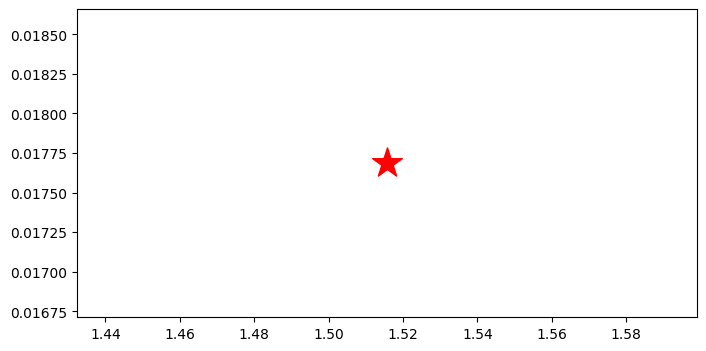

In [39]:
### 计算均值-方差模型得到最大夏普的市场权重
# 定义组合收益率和方差计算
def port_return(weights, returns):
    return np.sum(weights * returns.mean(axis = 0))

def port_volatility(weights, returns):
    return np.sqrt(np.dot(weights.T,np.dot(returns.cov(), weights)))

# 定义目标函数
def sharp_ratio(weights, returns, risk_free_date):
    portfolio_return = np.sum(weights * returns.mean(axis = 0))
    portfolio_volatility = np.sqrt(np.dot(weights.T,np.dot(returns.cov(), weights)))
    sharp_ratio = (portfolio_return - risk_free_date) / portfolio_volatility
    return -sharp_ratio
# 定义最优化函数（拉格朗日乘子法），计算最大夏普
initial_weitghts = np.ones(len(data_df_pivot.columns),)/len(data_df_pivot.columns)
bounds = [(0,1)] * len(data_df_pivot.columns)
constraints = (
    {'type':'eq','fun': lambda x: np.sum(x)-1}, #eq表示等式约束，表示等于0
    {'type':'ineq','fun':lambda x:x} #ineq表示不等式约束，表示大于等0，对应禁止卖空
)
# 求解权重
result = minimize(sharp_ratio, initial_weitghts,args=(data_df_pivot,Goverment_bond_YTM_10Y), method='SLSQP',bounds=bounds, constraints=constraints)
print(result.x, port_return(result.x, data_df_pivot), port_volatility(result.x, data_df_pivot))
# 绘制有效前沿曲线
plt.figure(figsize=(8,4))
plt.scatter(port_volatility(result.x, data_df_pivot),port_return(result.x, data_df_pivot), marker='*', color='r', s=500,
            label='Maximum Sharp ratio')

target_returns = np.linspace(0.0001, port_return(result.x, data_df_pivot), 1)
target_volatility = []

for tar in target_returns:
    constraints_for = (
    {'type':'eq','fun': lambda x: np.sum(x)-1}, #eq表示等式约束，表示等于0
    {'type':'eq','fun':lambda x: port_return(x, data_df_pivot)-x} #约束组合收益率等于tar。这样就可以得到在不同目标收益率下的最小方差
    )
    result_for = minimize(port_volatility,initial_weitghts,method='SLSQP',
                          bounds=bounds,
                          args=(data_df_pivot,Goverment_bond_YTM_10Y),
                          constraints=constraints_for)
    target_volatility.append(result_for.fun)
target_volatility = np.array(target_volatility)
plt.scatter(target_volatility,target_returns,c=(target_returns-Goverment_bond_YTM_10Y)/target_volatility, s=50,
            label = 'Efficient frontier') # c: 散点的颜色，可以是一个标量或者一个数组，这里是target_returns/target_vars，表示每个散点的颜色由其夏普比率决定
plt.grid(True)
plt.xlabel('Expected variance')
plt.ylabel('Expected return')
plt.legend(loc='best')
plt.show()

'''
scipy.optimize.minimize函数的返回值，是一个OptimizeResult对象，包含了最优化过程的信息。最优化结果result有以下属性：

x: 最优解
success: 布尔值，表示是否成功找到最优解
status: 整数，表示最优化过程的状态码
message: 字符串，表示最优化过程的终止原因
fun: 浮点数，表示目标函数在最优解处的值
jac: 数组，表示目标函数在最优解处的梯度
hess: 矩阵或者线性算子，表示目标函数在最优解处的海森矩阵或者近似
nfev: 整数，表示目标函数被调用的次数
njev: 整数，表示梯度被调用的次数
nhev: 整数，表示海森矩阵被调用的次数
nit: 整数，表示迭代次数
'''

array([1., 0.])

In [ ]:
### 计算先验分布：市场均衡权重、均衡收益率、风险厌恶系数、假定τ





In [ ]:
### 设定市场观点。计算观点矩阵、观点收益率向量、观点协方差矩阵


In [ ]:
### 计算后验分布收益率及方差



In [ ]:
### 计算后验分布的资产权重